In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from obspy import UTCDateTime

sys.path.append('seismo/src')
from stat_seismo import *

%matplotlib inline

# Apply the NND declustering on SEA data

In [2]:
# convert CSV to table 
raw_csv = "/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_all.csv"
raw_df = pd.read_csv(raw_csv, header = "infer")

raw_tab = "/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_all.h5"
raw_df.to_hdf(raw_tab, 'table')

out_fname = "/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_all_nnd.h5"

In [3]:
raw_df = pd.read_hdf(raw_tab, 'table')
raw_df.sort_values(by = "time", ascending = True, inplace = True)

In [4]:
import numpy as np
import pandas as pd
from mpi4py import MPI
from pathlib import Path

"""
Code originally from: https://github.com/florentaden/nnd_declustering
Modified such that the distance incorporates depth (3D distance)
"""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
doublesize = MPI.DOUBLE.Get_size()

# -- all CPUs communicator
ALL_COMM = MPI.COMM_WORLD
size = ALL_COMM.Get_size()
rank, size = ALL_COMM.Get_rank(), ALL_COMM.Get_size()

# -- all CPUs inside node communicator
NODE_COMM = ALL_COMM.Split_type(MPI.COMM_TYPE_SHARED)
node_rank, node_size = NODE_COMM.rank, NODE_COMM.size

# -- get one relay node per node
value = (rank, node_rank)
values = np.array(ALL_COMM.allgather(value))
relay_ranks = values[values[:, 1] == 0, 0]
group = ALL_COMM.group.Incl(relay_ranks)
RELAY_COMM = ALL_COMM.Create_group(group)

if rank in relay_ranks:
    boss_rank, boss_size = RELAY_COMM.rank, RELAY_COMM.size

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
b_value = 1.20
fractal_dimension = 1.6
q = 0.5
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# -- southern california 1981-2011
root_dir = Path("/Users/jgra0019/Documents/codes/seismo/seismo/data")
catalog_name = "sum_processed"
output_name = catalog_name + '_nnd'

# -- read catalog
catalog_df = pd.read_hdf(raw_tab, 'table')
catalog_df = catalog_df[catalog_df.magnitude >= 4.85]
# catalog_df = catalog_df.reindex(['year', 'month', 'day', 'hour', 'minute',
#     'seconde', 'time', 'latitude', 'longitude', 'depth', 'magnitude'], axis=1)
catalog_df = catalog_df.reindex(['year', 'month', 'day', 'hour', 'minute',
    'seconde', 'time', 'x_pos', 'y_pos', 'z_pos', 'magnitude', 'longitude', 'latitude', 'depth'], axis = 1) # new version - considers depth
catalog = np.array(catalog_df)

# -- apply declustering and give the children dataframe
children_df = catalog_df[1:]
number_of_children, number_of_columns = children_df.shape

""" shared children array (output) """
number_of_points = number_of_children * (number_of_columns + 5)
nbytes = doublesize * number_of_points
win = MPI.Win.Allocate_shared(nbytes if node_rank == 0 else 0, doublesize,
    comm=NODE_COMM)
buf, itemsize = win.Shared_query(0)
assert itemsize == MPI.DOUBLE.Get_size()
buf = np.array(buf, dtype='B', copy=False)
children = np.ndarray(buffer=buf, dtype='d', shape=(number_of_children,
    number_of_columns+5))

if node_rank == 0:
    children.fill(0)
    children[:, :number_of_columns] = np.array(children_df)

ALL_COMM.Barrier()

for j, child in list(enumerate(children))[rank::size]: # for each event
    # potential parents
    k = (catalog[:, 6] < child[6])
    parents = np.zeros((k.sum(), number_of_columns+5))
    parents[:, :number_of_columns] = catalog[k]

    # compute temporal distance with all parents
    parents[:, 14] = child[6] - parents[:, 6]
    parents[:, 14] = parents[:, 14]*10**(-q*b_value*parents[:, 10])

    # compute physical distance with all parents
    parents[:, 15] = np.sqrt((child[9]-parents[:, 9])**2 + (child[8]-parents[:, 8])**2 + \
                 (child[7]-parents[:, 7])**2)
    # added by JCG - calculate distance and incorporate the depth in calculation
    # convert spherical to cartesian
    parents[:, 15] = (parents[:, 15]**fractal_dimension)*10**(
        (q-1)*b_value*parents[:, 10])

    # compute nearest_neighbor_distance metric with all parents
    parents[:, 16] = parents[:, 14]*parents[:, 15]

    nearest_neighbor = np.argmin(parents[:, 16])
    children[j, 15] = parents[nearest_neighbor, 15]
    children[j, 14] = parents[nearest_neighbor, 14]
    children[j, 16] = parents[nearest_neighbor, 16]
    children[j, 17] = parents[nearest_neighbor, 10]
    children[j, 18] = nearest_neighbor

ALL_COMM.Barrier()

if rank in relay_ranks:
    if rank == 0:
        target = np.zeros_like(children)
    else:
        target = None

    RELAY_COMM.Reduce([children, MPI.DOUBLE], [target, MPI.DOUBLE], op=MPI.SUM,
        root=0)

if rank == 0:
    columns = ['year', 'month', 'day', 'hour', 'minute', 'seconde', 'time',
              'x', 'y', 'z', 'magnitude', 'longitude', 'latitude', 'depth',
              'Tij', 'Rij', 'Nij', 'parent_magnitude', 'neighbor']
    children_df = pd.DataFrame(target, columns=columns)
    #children_df.to_hdf(root_dir/(output_name + '.h5'), 'table')


In [5]:
nnd_df = children_df

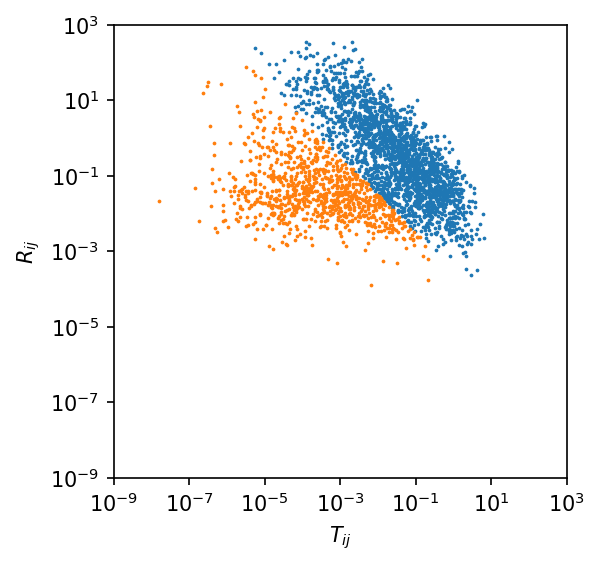

In [6]:
thresh = 10**-3.5
g1 = nnd_df[nnd_df["Nij"] > thresh]
g2 = nnd_df[nnd_df["Nij"] < thresh]
fig, ax = plt.subplots(dpi = 150)

ax.plot(g1["Tij"], g1["Rij"], 'o', markersize = 0.8, color = "C0")
ax.plot(g2["Tij"], g2["Rij"], 'o', markersize = 0.8, color = "C1")

# labels
ax.set_xlabel(r"$T_{ij}$")
ax.set_ylabel(r"$R_{ij}$")

# other settings
ax.set_xlim([1e-9, 1e3])
ax.set_ylim([1e-9, 1e3])
ax.loglog()
ax.set_aspect(1)

Text(0.5,0,'log $N_{ij}$')

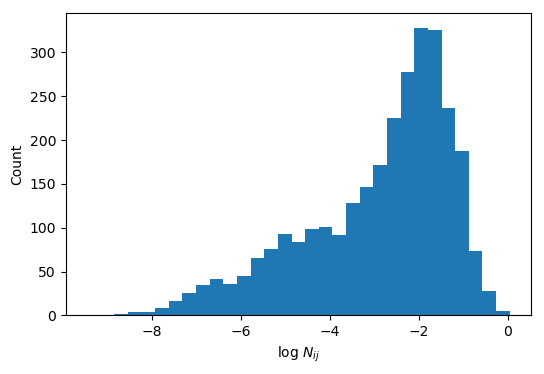

In [7]:
x_use = np.array(nnd_df[nnd_df["Nij"] > 0]["Nij"])
x_log = np.log10(x_use)
fig, ax = plt.subplots(dpi = 100)
ax.hist(x_log, bins = "fd")
ax.set_ylabel("Count")
ax.set_xlabel(r"log $N_{ij}$")

In [8]:
# save the nnd_df
print(out_fname)
nnd_df.to_csv(out_fname, header = True, index = False)

/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_all_nnd.h5


In [9]:
# try to read the data and solve Zuhair's problem
nnd_df = pd.read_csv("/Users/jgra0019/Documents/codes/seismo/seismo/data/sum_20_all_nnd.h5", header = "infer")
nnd_df["second"] = nnd_df["seconde"] 

In [23]:

data = nnd_df
data["date"] = pd.to_datetime(data[["year", "month", "day", "hour", "minute", "second"]])

In [31]:
selected_value = UTCDateTime(data["date"].loc[0])
years_passed = []

for idx, row in nnd_df["date"].iteritems():
    years_passed.append(UTCDateTime(row) - selected_value)

years_passed = np.array(years_passed)/31536000

data["YEARS"] = years_passed
data = data.sort_values(by = "YEARS", ascending = True)

In [30]:
years_passed.max()

42.006175577118213